# PHINDR3D Results and clustering

This notebook helps visualize Phindr3D results and can perform affinity propagation clustering.

code marked `EDIT HERE` may be edited as needed to get desired results.

In [1]:
import phindr_functions as phi
import phindr_organoidCSApp as org
import phindr_clustering as clu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# File Loading

Load saved image feature file and filter as needed.

In [2]:
#path to csv file: EDIT HERE
folder = r''
filename = 'neuronimagefeatures.csv'

Filter_NaN =  False #filter out images with "Not a number" megavoxel frequencies (happens when no megavoxels found)

#file loading
if len(folder) != 0:
    filename = folder + '\\' + filename
 
image_feature_data = pd.read_csv(filename, index_col=0) #need to skip first row because an unnamed row gets added somehow when saving the data.
if Filter_NaN:
    image_feature_data = image_feature_data.dropna()
    
from IPython.display import display
display(image_feature_data)


,ImageID,treatment,numMV,MV1,MV2,MV3,MV4,MV5,MV6,MV7,...,MV31,MV32,MV33,MV34,MV35,MV36,MV37,MV38,MV39,MV40
0,r03c19f01,r03c19,264.0,0.0,0.003788,0.000000,0.113636,0.003788,0.007576,0.003788,...,0.007576,0.000000,0.018939,0.000000,0.000000,0.011364,0.060606,0.000000,0.018939,0.000000
1,r03c19f02,r03c19,188.0,0.0,0.000000,0.079787,0.015957,0.015957,0.042553,0.000000,...,0.079787,0.010638,0.015957,0.037234,0.026596,0.010638,0.015957,0.000000,0.026596,0.010638
2,r03c19f03,r03c19,247.0,0.0,0.024291,0.040486,0.040486,0.024291,0.028340,0.000000,...,0.012146,0.004049,0.024291,0.032389,0.016194,0.036437,0.012146,0.004049,0.032389,0.004049
3,r03c19f04,r03c19,231.0,0.0,0.004329,0.060606,0.000000,0.012987,0.030303,0.000000,...,0.116883,0.034632,0.012987,0.056277,0.108225,0.021645,0.000000,0.000000,0.012987,0.008658
4,r03c19f05,r03c19,102.0,0.0,0.009804,0.049020,0.009804,0.078431,0.029412,0.000000,...,0.058824,0.019608,0.019608,0.107843,0.039216,0.000000,0.009804,0.000000,0.039216,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,r04c22f06,r04c22,256.0,0.0,0.027344,0.000000,0.085938,0.015625,0.011719,0.082031,...,0.003906,0.019531,0.003906,0.000000,0.000000,0.035156,0.031250,0.015625,0.093750,0.023438
76,r04c22f07,r04c22,84.0,0.0,0.000000,0.000000,0.011905,0.000000,0.023810,0.095238,...,0.000000,0.023810,0.000000,0.000000,0.011905,0.071429,0.083333,0.059524,0.023810,0.011905
77,r04c22f08,r04c22,157.0,0.0,0.000000,0.006369,0.089172,0.000000,0.012739,0.050955,...,0.000000,0.006369,0.000000,0.000000,0.012739,0.044586,0.012739,0.000000,0.076433,0.012739
78,r04c22f09,r04c22,94.0,0.0,0.021277,0.021277,0.000000,0.053191,0.021277,0.042553,...,0.021277,0.021277,0.021277,0.010638,0.021277,0.010638,0.021277,0.031915,0.010638,0.010638


In [3]:
# Filter dataframe as needed:
#   to filter the dataframe (e.g. to only select orws with specific range of values):
#   set filter_data to True below, change FILTER COLUMN to the desired column, 
#   change FILTER VALUE to the desired value, and check that the operation (==, >, <, <=, >=) is correct.
#   copy and paste the indented filter control lines below to add aditional filtering as needed.
filter_data = True
if filter_data:
    image_feature_data.replace(['r03c19', 'r04c19'], 'medium', inplace=True)
    image_feature_data.replace(['r03c20', 'r04c20'], 'DMSO', inplace=True)
    image_feature_data.replace(['r03c21', 'r04c21'], 'ActinomycinD 10nM', inplace=True)
    image_feature_data.replace(['r03c22', 'r04c22'], 'Staurosporine 100nM', inplace=True)
    # filter = image_feature_data['FILTER_COLUMN'] >= 'FILTER_VALUE' #set filter
    # image_feature_data = image_feature_data[filter] #apply filter

# copy the format of the lines above to add more filters. 


#get misc values
num_images_kept = image_feature_data.shape[0]
print(f'\nNumber of images: {num_images_kept}\n')
columns = image_feature_data.columns
imageIDs = np.array(image_feature_data['ImageID'], dtype='object')
uniqueIDs = np.unique(imageIDs)
treatments = np.array(image_feature_data['treatment'], dtype='object')
Utreatments = np.unique(treatments)
numMVperImg = np.array(image_feature_data['numMV'])

numMV = image_feature_data.shape[1]-3
mv_cols = columns[3:] #all columns corresponding to megavoxel categories
MV_freqs = image_feature_data[mv_cols].to_numpy()
print(MV_freqs.shape)
print(Utreatments)
from IPython.display import display
display(image_feature_data)


Number of images: 80

(80, 40)
['ActinomycinD 10nM' 'DMSO' 'Staurosporine 100nM' 'medium']


,ImageID,treatment,numMV,MV1,MV2,MV3,MV4,MV5,MV6,MV7,...,MV31,MV32,MV33,MV34,MV35,MV36,MV37,MV38,MV39,MV40
0,r03c19f01,medium,264.0,0.0,0.003788,0.000000,0.113636,0.003788,0.007576,0.003788,...,0.007576,0.000000,0.018939,0.000000,0.000000,0.011364,0.060606,0.000000,0.018939,0.000000
1,r03c19f02,medium,188.0,0.0,0.000000,0.079787,0.015957,0.015957,0.042553,0.000000,...,0.079787,0.010638,0.015957,0.037234,0.026596,0.010638,0.015957,0.000000,0.026596,0.010638
2,r03c19f03,medium,247.0,0.0,0.024291,0.040486,0.040486,0.024291,0.028340,0.000000,...,0.012146,0.004049,0.024291,0.032389,0.016194,0.036437,0.012146,0.004049,0.032389,0.004049
3,r03c19f04,medium,231.0,0.0,0.004329,0.060606,0.000000,0.012987,0.030303,0.000000,...,0.116883,0.034632,0.012987,0.056277,0.108225,0.021645,0.000000,0.000000,0.012987,0.008658
4,r03c19f05,medium,102.0,0.0,0.009804,0.049020,0.009804,0.078431,0.029412,0.000000,...,0.058824,0.019608,0.019608,0.107843,0.039216,0.000000,0.009804,0.000000,0.039216,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,r04c22f06,Staurosporine 100nM,256.0,0.0,0.027344,0.000000,0.085938,0.015625,0.011719,0.082031,...,0.003906,0.019531,0.003906,0.000000,0.000000,0.035156,0.031250,0.015625,0.093750,0.023438
76,r04c22f07,Staurosporine 100nM,84.0,0.0,0.000000,0.000000,0.011905,0.000000,0.023810,0.095238,...,0.000000,0.023810,0.000000,0.000000,0.011905,0.071429,0.083333,0.059524,0.023810,0.011905
77,r04c22f08,Staurosporine 100nM,157.0,0.0,0.000000,0.006369,0.089172,0.000000,0.012739,0.050955,...,0.000000,0.006369,0.000000,0.000000,0.012739,0.044586,0.012739,0.000000,0.076433,0.012739
78,r04c22f09,Staurosporine 100nM,94.0,0.0,0.021277,0.021277,0.000000,0.053191,0.021277,0.042553,...,0.021277,0.021277,0.021277,0.010638,0.021277,0.010638,0.021277,0.031915,0.010638,0.010638


# Sammon Mapping
Make sammon map of Phindr3D data


20
20
20
20


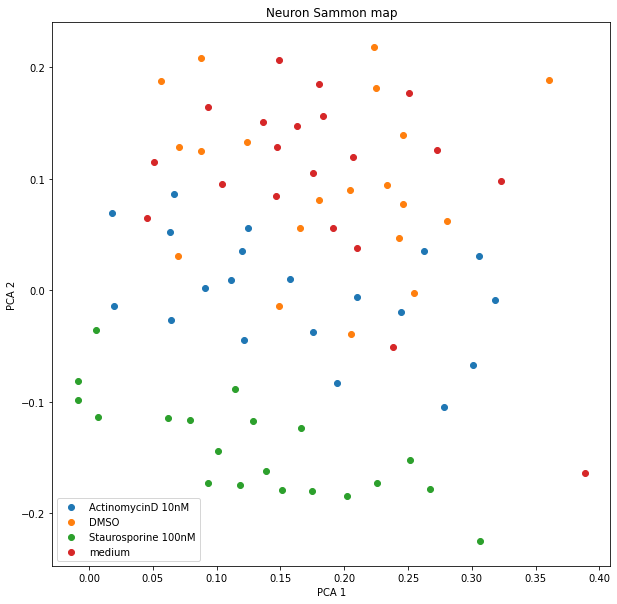

In [4]:
#plot parameters: EDIT HERE
title = 'Neuron Sammon map'
xlabel = 'PCA 1'
ylabel = 'PCA 2'

X = MV_freqs
y = imageIDs
z = treatments

S, E = clu.sammon(X, 2)

plt.figure(figsize=(10,10))
for treat in Utreatments:
    plt.scatter(S[z==treat, 0], S[z==treat, 1], label=treat)
    print(np.sum(z==treat))
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

# PCA plot
Make PCA plot of phindr3D results. currently uses kernel PCA with a variable function since it seems to get best results here. 

See https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html for more information on types of PCA availble.

20
20
20
20


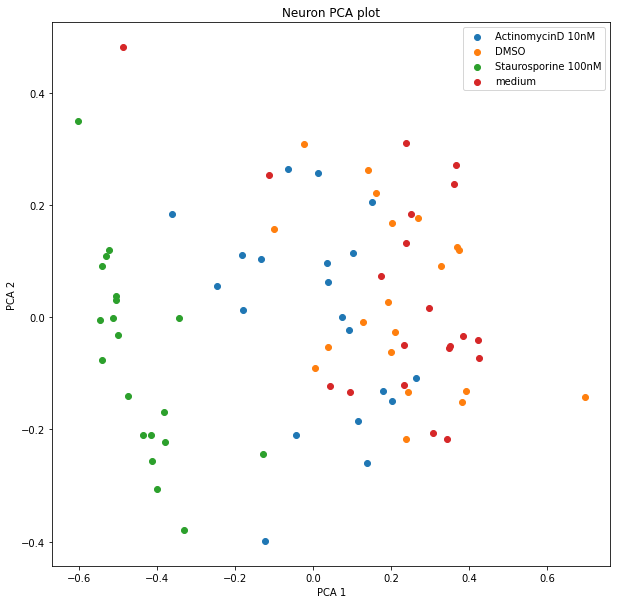

In [5]:
#PCA kernel function: EDIT HERE
#set as 'linear' for linear PCA, 'rbf' for gaussian kernel, 
#'sigmoid' for sigmoid kernel, 
#'cosine' for cosine kernel
func = 'sigmoid'

#plot parameters: EDIT HERE
title = 'Neuron PCA plot'
xlabel = 'PCA 1'
ylabel = 'PCA 2'

#makes plot 
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
X = MV_freqs
y = imageIDs
z = treatments

sc = StandardScaler()
X_show = sc.fit_transform(X)
pca = KernelPCA(n_components=2, kernel=func) 
P = pca.fit(X_show).transform(X_show)

plt.figure(figsize=(10,10))
for treat in Utreatments:
    plt.scatter(P[z==treat, 0], P[z==treat, 1], label=treat)
    print(np.sum(z==treat))
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()


# t-SNE

Make t-SNE plot of phindr3D data. 

t-SNE is not a deterministic method, results may vary between different runs. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for additional parameters to use


C:\Users\teole\anaconda3\envs\phy479\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\teole\anaconda3\envs\phy479\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


20
20
20
20


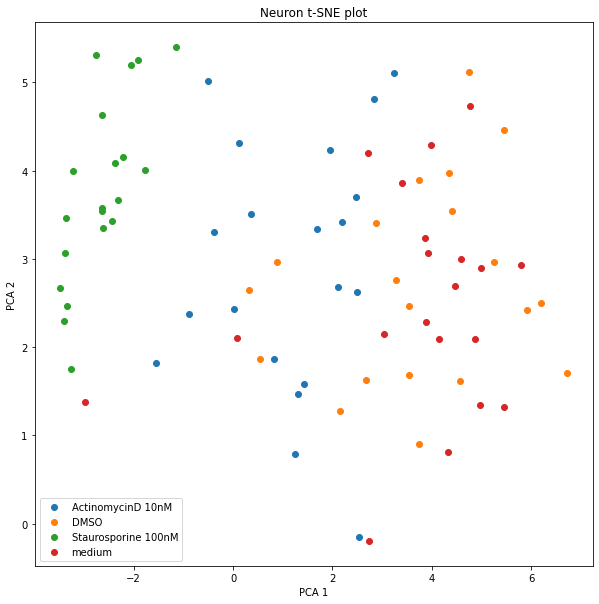

In [20]:
#plot parameters: EDIT HERE
title = 'Neuron t-SNE plot'
xlabel = 'PCA 1'
ylabel = 'PCA 2'


X = MV_freqs
y = imageIDs
z = treatments

from sklearn.manifold import TSNE
T = TSNE(n_components=2).fit_transform(X) #can edit here from tsne documentation.

plt.figure(figsize=(10,10))
for treat in Utreatments:
    plt.scatter(T[z==treat, 0], T[z==treat, 1], label=treat)
    print(np.sum(z==treat))
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

# AP clustering
cluster phindr3D results into k clusters using affinity propagation. This process may take a few minutes.

In [9]:
#clustering parameters: EDIT HERE
Nclusters = 4 #number of clusters to try to hit
percent_dev = 10 #percentage by which final number of clusters may deviate from Nclusters


#performs clustering
C = clu.clsIn(MV_freqs) #make similarity matrix
idx, netsim, dpsim, expref, pref = clu.apclusterK(C.S, Nclusters, prc=percent_dev)
clusters, counts = np.unique(idx, return_counts=True)
print('\n')
for i in range(len(clusters)):
    print(f'cluster{i+1}: {counts[i]} counts')

algorithm did not converge, similarities may contain degeneracies - add noise to similarities to remove degeneracies.
To monitor net similarity, activate plotting. Also consider increasing maxits and if necessary, dampfact.
applyng bisection method
algorithm did not converge, similarities may contain degeneracies - add noise to similarities to remove degeneracies.
To monitor net similarity, activate plotting. Also consider increasing maxits and if necessary, dampfact.
Found 4 clusters using a preference of -0.5634661273472781


cluster1: 2 counts
cluster2: 44 counts
cluster3: 10 counts
cluster4: 24 counts


# Cluster visualization
- Show clusters in reduced dimensionality plot
- cluster pie charts
- cluster heatmaps

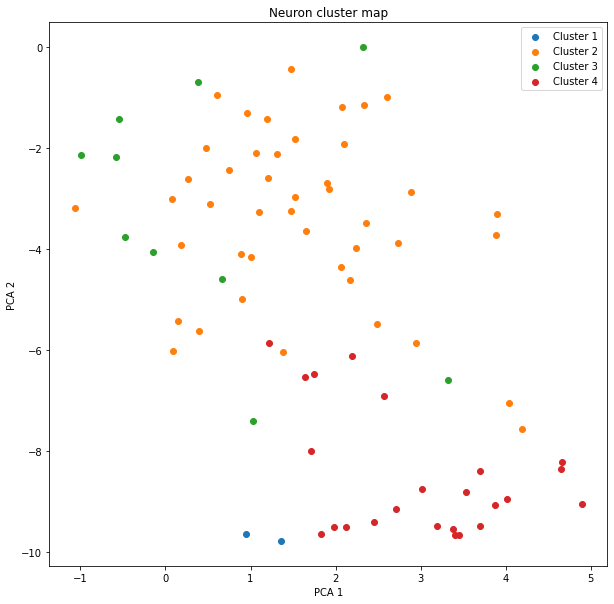

In [12]:
#visualize clusters

#choose type of mapping: EDIT HERE
#options: 'sammon', 'pca', 'tsne'
map_type = 'sammon'

#plot parameters: EDIT HERE
title = 'Neuron cluster map'
xlabel = 'PCA 1'
ylabel = 'PCA 2'


if map_type.lower() == 'sammon':
    show = S
elif map_type.lower() == 'tsne':
    show = T
elif map_type.lower() == 'pca':
    show = P
#makes plot
plt.figure(figsize=(10,10))
for i in range(len(clusters)):
    plt.scatter(show[idx==clusters[i], 0], show[idx==clusters[i], 1], label=f'Cluster {i+1}')
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

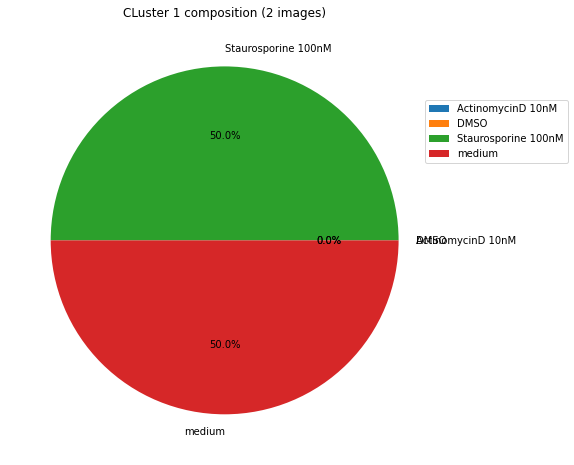

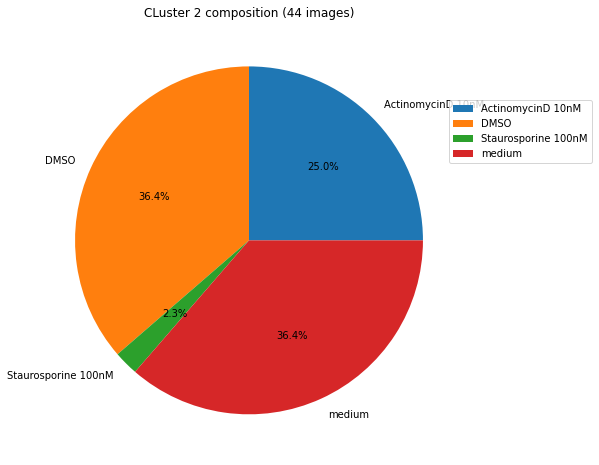

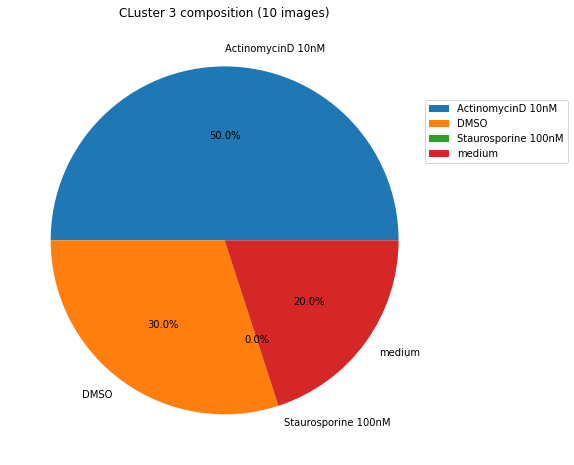

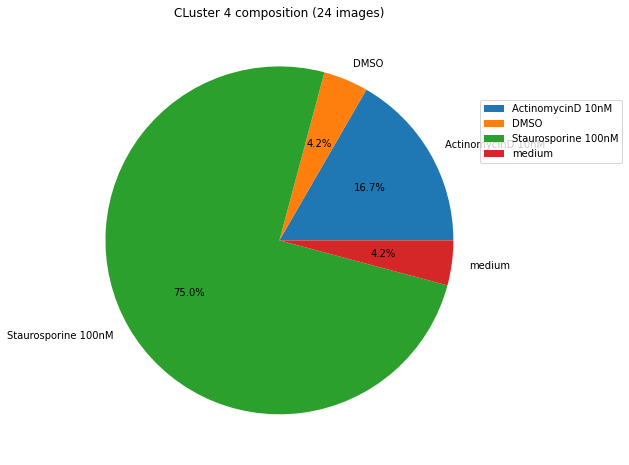

In [13]:
#make pie charts for each cluster
#pie chart making is all automated, only need to run this cell.


def percent(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%".format(pct, absolute)

z = treatments

for i in range(len(clusters)): 
    counts = np.zeros(len(Utreatments))
    for j, treat in enumerate(Utreatments):
        counts[j] = np.sum(np.logical_and(z==treat, idx==clusters[i]))
    labels = Utreatments
    fig, ax = plt.subplots(figsize=(15,8))
    title = f'CLuster {i+1} composition ({round(np.sum(counts))} images)'
    ax.set_title(title)
    wedges, texts, autotexts = ax.pie(counts, labels=labels, autopct= lambda pct:percent(pct, counts))
    ax.legend(wedges, labels, loc='center right', bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))

plt.show()

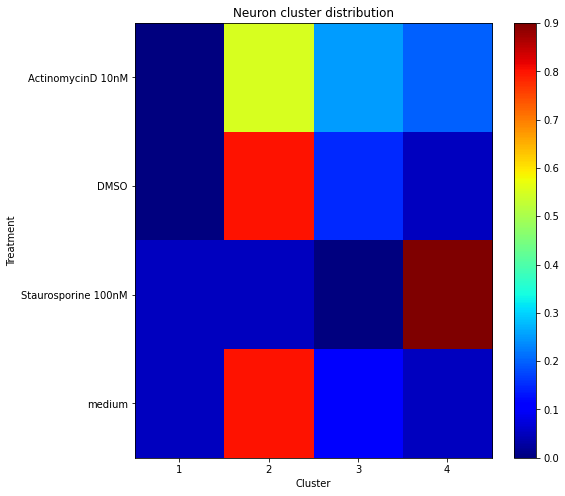

In [14]:
#make heatmap of cluster distribution for each treatment
#plot parameters: EDIT HERE
title = 'Neuron cluster distribution'
xlabel = 'Cluster'
ylabel = 'Treatment'

map = np.zeros((len(Utreatments), len(clusters)))
for i, treat in enumerate(Utreatments):
    for j in range(len(clusters)):
        map[i, j] = np.sum(np.logical_and(treatments==treat, idx==clusters[j]))

#normalize the cluster counts for each treatment
row_sum = np.sum(map, axis=1)
map = map / row_sum[:, np.newaxis]
map_bad = np.logical_not(np.isfinite(map)) #clean up any potential divide by 0 errors
map[map_bad] = 0
    
#make plot
plt.figure(figsize=(8,8))
plt.title(title)
plt.imshow(map, cmap='jet', aspect='auto')
plt.xticks(ticks=[i for i in range(0, len(clusters))], labels=[f'{i}' for i in range(1, len(clusters)+1)])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.yticks(ticks=[i for i in range(len(Utreatments))], labels=Utreatments)
plt.colorbar()
plt.show()

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (4).

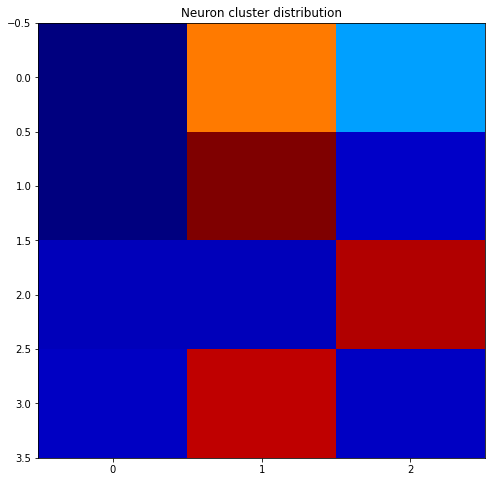

In [15]:
#make heatmap of cluster distribution for each treatment
#plot parameters: EDIT HERE
title = 'Neuron cluster distribution'
xlabel = 'Cluster'
ylabel = 'Treatment'

fclusters = np.delete(clusters, 2)

map = np.zeros((len(Utreatments), len(fclusters)))
for i, treat in enumerate(Utreatments):
    for j in range(len(fclusters)):
        map[i, j] = np.sum(np.logical_and(treatments==treat, idx==fclusters[j]))

#normalize the cluster counts for each treatment
row_sum = np.sum(map, axis=1)
map = map / row_sum[:, np.newaxis]
map_bad = np.logical_not(np.isfinite(map))
map[map_bad] = 0

    
#make plot
plt.figure(figsize=(8,8))
plt.title(title)
plt.imshow(map, cmap='jet', aspect='auto')
plt.xticks(ticks=[i for i in range(0, len(fclusters))], labels=[1,2,4,5])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.yticks(ticks=[i for i in range(len(Utreatments))], labels=Utreatments)
plt.colorbar()
plt.show()

# misc not done yet
cells below are extra, not really needed right now.

# t-SNE
clusters are ugly, keep here just in case

In [ ]:
from sklearn.manifold import TSNE 
X_r = TSNE(n_components=2, learning_rate='auto', perplexity = 35, init='pca').fit_transform(X_show)
print(X_embedded.shape)
plt.figure()
for treat in Utreatments:
    plt.scatter(X_r[z==treat, 0], X_r[z==treat, 1], label=treat)
    plt.legend()
plt.show()

C:\Users\teole\anaconda3\envs\phy479\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


NameError: name 'X_embedded' is not defined

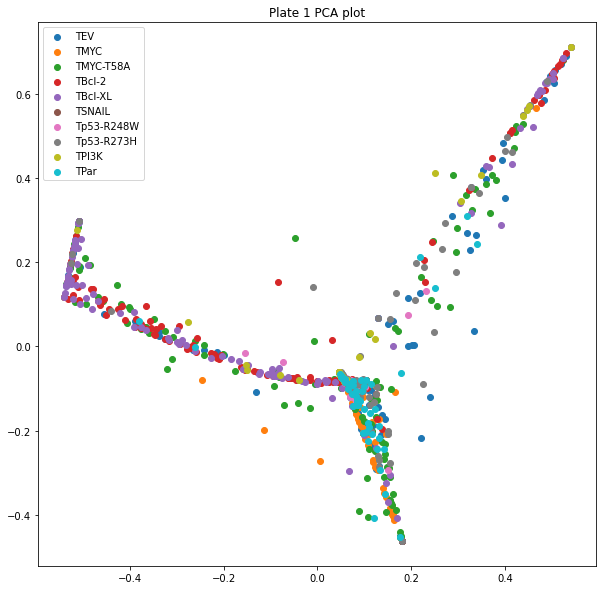

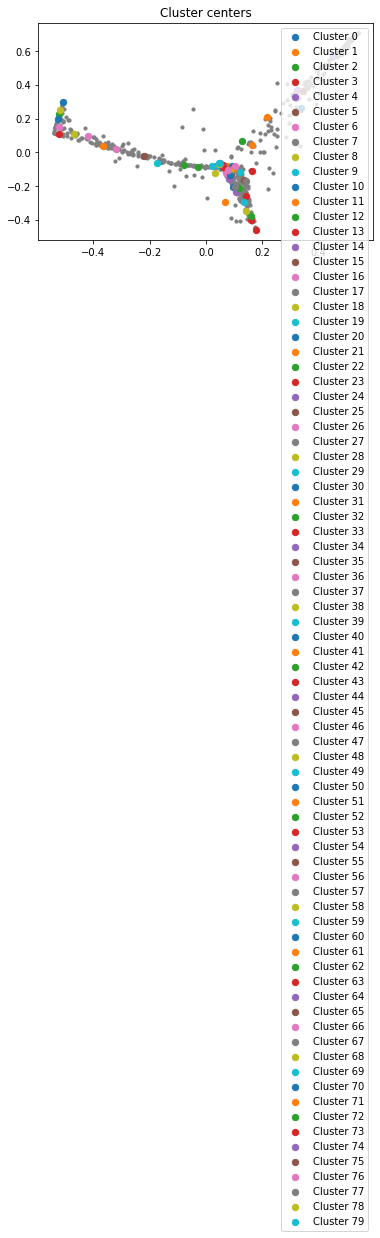

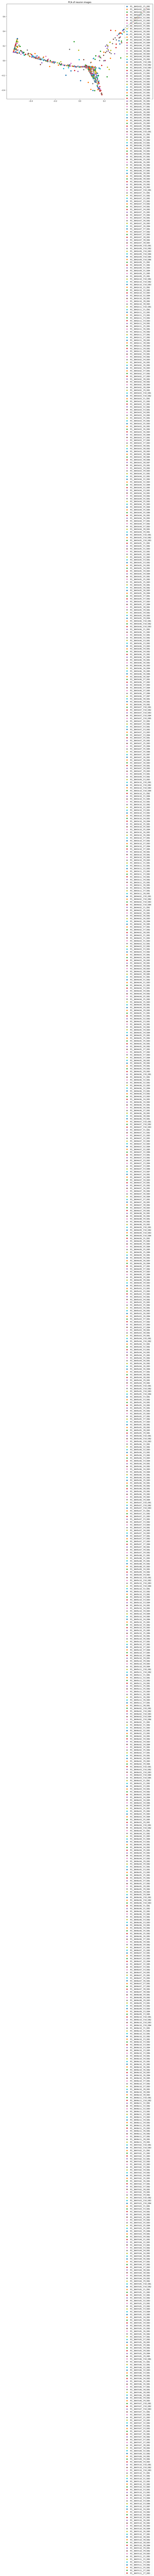

In [ ]:
from sklearn.decomposition import PCA
X = MV_freqs
y = imageIDs
z = treatments

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

Utreatments = ['TEV', 'TMYC', 'TMYC-T58A', 'TBcl-2', 'TBcl-XL', 'TSNAIL', 'Tp53-R248W',
 'Tp53-R273H', 'TPI3K', 'TPar']

plt.figure(figsize=(10,10))
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:olive', 'chartreuse']
for treat in Utreatments:
    plt.scatter(X_r[z==treat, 0], X_r[z==treat, 1], label=treat)
plt.legend()
plt.title('Plate 1 PCA plot')
plt.show()

plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1], s=10, color='gray')
for i, indx in enumerate(cluster_center_indices):
    plt.scatter(X_r[indx, 0], X_r[indx, 1], s=40, label=f'Cluster {i}')
plt.title('Cluster centers')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
# colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', 'blue', 'orangered', 'rebeccapurple', 'lime']
for i, ID in enumerate(uniqueIDs):
    plt.scatter(X_r[y==ID, 0], X_r[y==ID, 1], s=40, label=ID)
plt.legend()
plt.title('PCA of neuron images')
plt.show()
